# 1. Vector Quantization (1H-1H30)

(A) First of all, start by finalizing the given competive learning algorithm, complete the update rule for the centroid and for the learning rate value, $\alpha$.

(B) Afterwards you'll need to implement the following algorithms:
1. Frequency sensitive learning (a slight alteration of competitive learning)
2. K-means (a batched form of competitive learning)
3. **[@Home]** Implement the neural gas algorithm (a winner-take-most alteration of competitive learning)

(C) You'll try out 3 different centroid initializations for these algorithms:
1. A (given) *random* init
2. A *random selection* of points
3. KMeans++

Test those 3 initializations with the 4 given datasets and answer the following questions:
* For each algorithm, which initialization works best and why?
* Should you apply a larger/lower learning rate to K-means? Why?

Answers:
* K-means++ for K-means and sampling for the others because of forgotten centroids (centroids that have no assigned points). FSL does partly solve this last problem
* K-means uses a batch update and thus its learning rate can be bumped up, otherwise it will converge too early due to the annealing of $\alpha$.


In [1]:
# -- Imports
import matplotlib
from show_functions import show_quantization

import scipy.io
import numpy as np
import random
from matplotlib import pyplot as plt
try:
    import seaborn as sns
    use_seaborn = True
    sns.set()
except:
    use_seaborn = False

## A.0 Competitive Learning

In [2]:
# -- Competitive Learning
def comp_learning(X: np.ndarray, Y: np.ndarray, n_epochs: int = 100, alpha: float = 0.1, beta: float = 0.99, min_epsilon: float = 1e-3):
    return Y, 0
    """ Computes and returns the centroids updated via the competitive learning algorithm
        
        Args:
            X: a matrix of shape PxD representing the data-points
            Y: a matrix of shape QxD representing the centroids' initilization
            n_epochs: the maximum number of epochs before stopping the algorithm
            alpha: the learning rate
            beta: the learning rate annealing rate
            min_epsilon: the minimal stopping criterion
        
        Returns:
            Y: a matrix of shape QxD containing the new centroid
            epoch: the number of epochs before returning (is always <= n_epochs)
    """
    assert len(X.shape)==2 and len(Y.shape)==2, f"Expected X and Y to both be 2D matrices but instead got {X.shape} and {Y.shape}"
    for epoch in range(n_epochs):
        prev_Y = Y.copy()
        
        # Shuffle Data
        np.random.shuffle(X)
        
        # Use up every data point
        for xp in X:
            #closest centroid
            index = np.argmin(np.sum(xp-Y),axis=-1)
            #update closest centroid
            yq = Y[index,:]
            Y[index,:]=yq + alpha * (xp - yq)

        # Update Learning Rate
        alpha = alpha*beta / (alpha+beta)
        
        # 'Intelligent' stopping criterion
        if np.mean(np.abs(prev_Y-Y)) < min_epsilon:
            print(f"Stopped at epoch {epoch}")
            break

    return Y, epoch+1

## B.1 Frequency Sensitive Learning

In [3]:
# -- Frequency Sensitive Learning
def fsl(X, Y, n_epochs=100, alpha=0.1, beta=0.99, min_epsilon=1e-3):
    """ Computes and returns the centroids updated via the Frequency Sensitive Learning algorithm
    """
    assert len(X.shape)==2 and len(Y.shape)==2, f"Expected X and Y to both be 2D matrices but instead got {X.shape} and {Y.shape}"
    u = np.ones(Y.shape[0])
    for epoch in range(n_epochs):
        prev_Y = Y.copy()
        
        # Shuffle Data
        np.random.shuffle(X)
        
        # Use up every data point
        for xp in X:
            #closest centroid
            Z = np.linalg.norm(xp-Y,axis=-1)
            index = np.argmin(u*Z)
            
            #update weight
            u[index]+=1
            
            #update closest centroid
            yq = Y[index,:]
            Y[index,:]=yq + alpha * (xp - yq)

        # Update Learning Rate
        alpha = alpha*beta / (alpha+beta)
        
        # 'Intelligent' stopping criterion
        if np.mean(np.abs(prev_Y-Y)) < min_epsilon:
            print(f"Stopped at epoch {epoch}")
            break

    return Y, epoch+1
   

## B.2 K-means

In [4]:
# -- K-means
def kmeans(X, Y, n_epochs=100, min_epsilon=1e-3, use_broadcasting=True):
    """ Computes and returns the centroids updated via the K-means algorithm
    
        Args:
            use_broadcasting: if True will use more memory for the K-means algorithm
    """
    assert len(X.shape)==2 and len(Y.shape)==2, f"Expected X and Y to both be 2D matrices but instead got {X.shape} and {Y.shape}"
    
    pass

## B.3 Neural Gas

In [5]:
# -- Neural Gas
def neural_gas(X, Y, lambda0=0.5, n_epochs=100, alpha=0.1, beta=0.99, min_epsilon=1e-3):
    """ Computes and returns the centroids updated via the Neural Gas algorithm
    
        Args:
            lambda0: The higher lambda0, the more influence far away points will have
    """
    assert len(X.shape)==2 and len(Y.shape)==2, f"Expected X and Y to both be 2D matrices but instead got {X.shape} and {Y.shape}"
    
    pass

## C. Different Initializations

In [6]:
# -- Kmeans++ init
def kmeans_pp(X: np.ndarray, Q: int):
    """ Computes Q centroids for X following the kmeans++ init. algorithm
        
        Args:
            X: a matrix of shape PxD representing the data-points
            Q: the number of centroids
        
        Returns:
            Y: a matrix of shape QxD containing the initialized centers
    """
    Y = np.zeros((Q, X.shape[-1]))
    indices = np.array(range(len(X)))
    Y[0] = X[np.random.choice(indices)]
    for q in range(1, Q):
        distances = np.min(np.sum((X-Y[:q, np.newaxis])**2, axis=-1), axis=0)
        index = np.random.choice(indices, p=distances/np.sum(distances))  # Distances with already chosen point will be ≃ 0, thus unlikely to pe picked
        Y[q] = X[index]
    return Y

def get_inits(X, Q, i):
    inits = {}
    mini = np.min(X, axis=0)
    maxi = np.max(X, axis=0)
    if i == 1:
        inits["Crappy"] = np.array([
            [0,3],[1,0],[1,1.5]
        ])
    elif i == 2:
        inits["Crappy"] = np.array([
            [0,0],[0,0.]
        ])

    inits["Random"] = np.array([
        np.random.uniform(mini[0],maxi[0],Q),
        np.random.uniform(mini[1],maxi[1],Q),
    ]).reshape(Q,2)
    inits["Sample"] = np.array(random.sample(X.tolist(), Q))
    inits["Kmeans++"] = kmeans_pp(X, Q)
    return inits

## D. VQ-loop

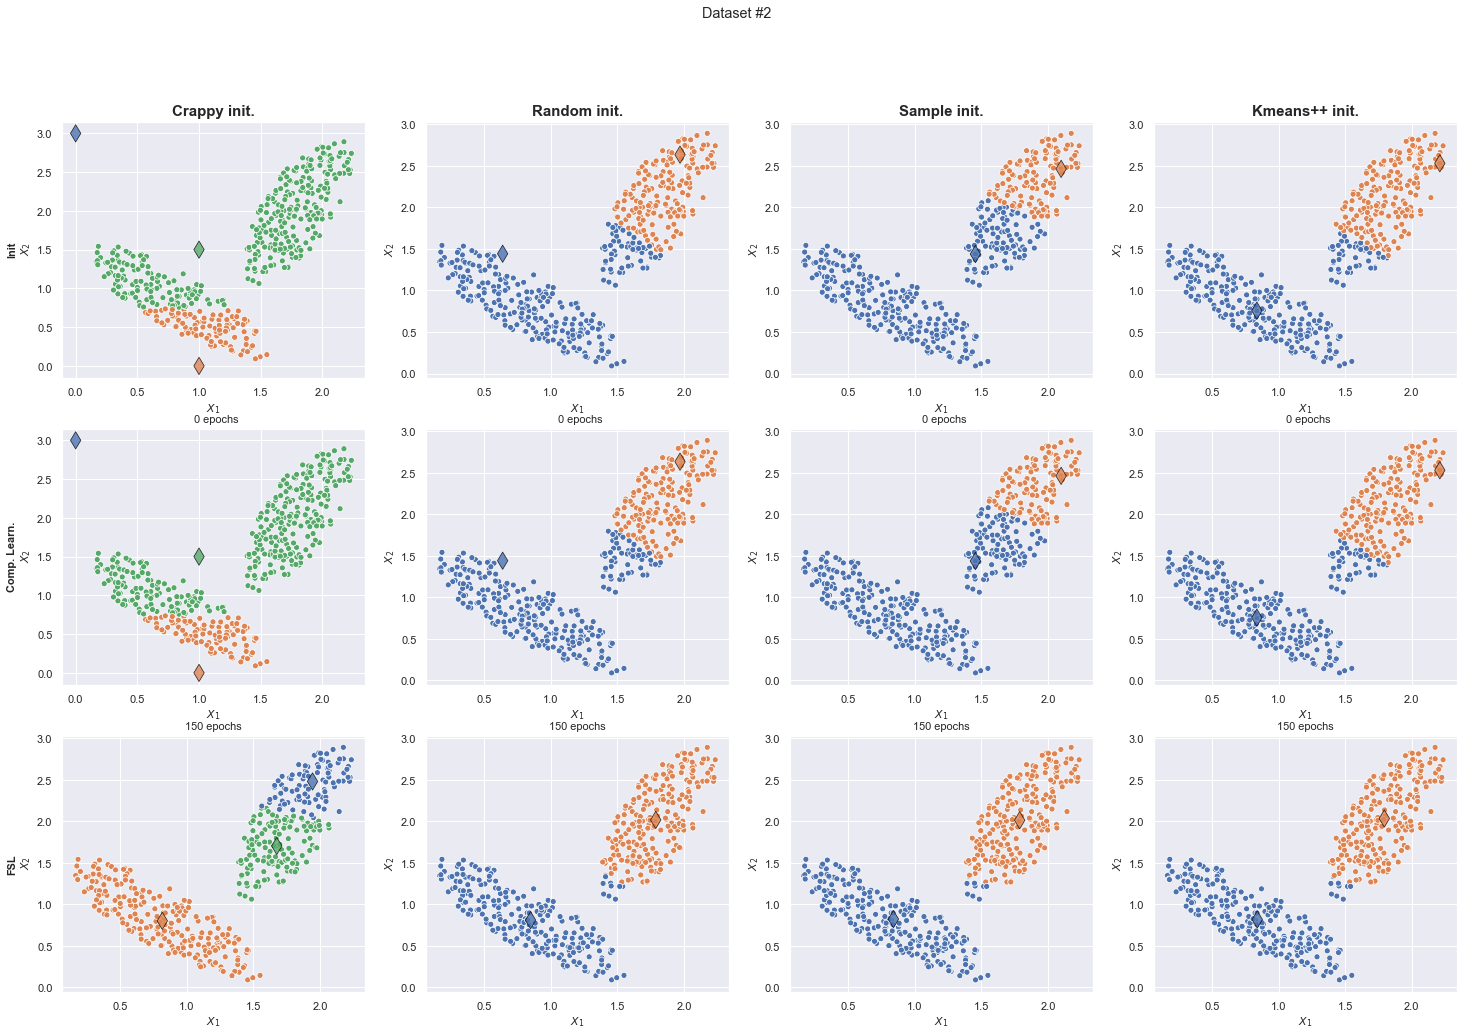

In [7]:
data = {}
for i in range(1,5):
    df = scipy.io.loadmat(f"data1/dataset_{i}.mat")
    data[i-1] = df['X']

# Uncomment more functions once you've implemented them
fxs = {"Init": (lambda x,y,*args,**kwargs: (y,0)), "Comp. Learn.": comp_learning, "FSL": fsl}#, "K-means": kmeans}#, "Neural Gas": neural_gas}
Q = 2
i = 1
X = data[i]
X = np.array(X)
all_Y_inits = get_inits(X, Q, i)

fig = plt.figure(figsize=((len(all_Y_inits)+1)*5, 1+5*len(fxs)))
idx = 1
for cl_type, fx in fxs.items():
    for init_idx, (init_type, Y_init) in enumerate(all_Y_inits.items()):
        ax = fig.add_subplot(len(fxs), len(all_Y_inits), idx)
        centroids, fit_epochs = fx(X, Y_init.copy(), n_epochs=150)
        
        show_quantization(X, centroids, use_seaborn=use_seaborn, ax=ax, name=(cl_type if init_idx==0 else None))
        
        idx += 1
        if cl_type=="Init":
            ax.set_title(f"{init_type} init.", fontweight="bold", fontsize=15)
        else:
            ax.set_title(f"{fit_epochs:3d} epochs", fontsize=11)
    

fig.suptitle(f"Dataset #{i+1}")
plt.show()
plt.close()

# Linear Regression
## Correlation and Univariate regression

This part constitutes an introduction to linear regression.
* **Load the dataset** and plot each feature in function of the blood sugar levels. If you had to select 1 feature only, which one would you keep? 
* **Implement the correlation** (numpy.corrcoef) factor to check your answer. What does a negative correlation mean?
* **Plot** the resulting linear regression

Correlation:  [ 0.18788875  0.043062    0.58645013  0.44148176  0.21202248  0.17405359
 -0.39478925  0.43045288  0.56588259  0.38248348]
Index of max correlation:  2


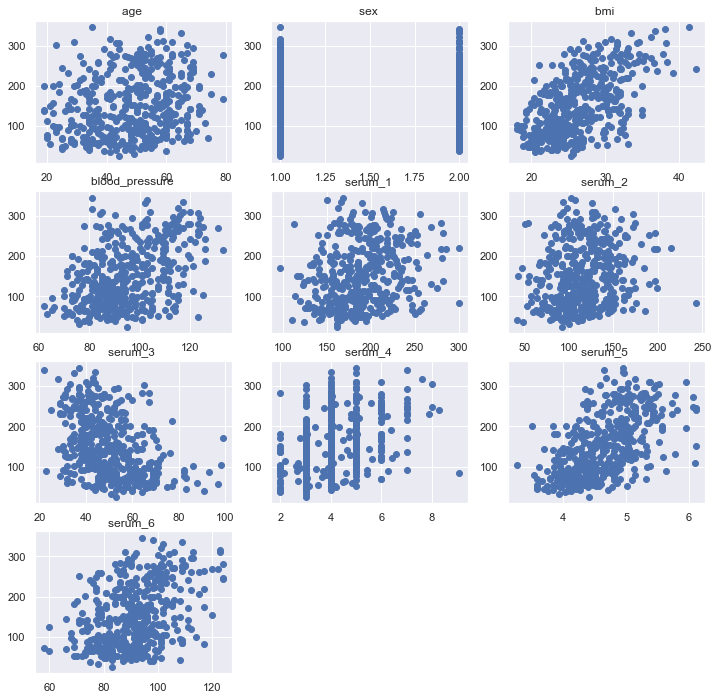

In [9]:
df = scipy.io.loadmat(f"data2/diabetes.mat")
X = df["X"]
n_samples, n_feats = X.shape
t = df["t"]
t = t[:,0]
t_names = ["age", "sex", "bmi", "blood_pressure", "serum_1", 
           "serum_2", "serum_3", "serum_4", "serum_5", "serum_6"]

correlation = np.zeros(10,)
for i in range (10):
    res = np.corrcoef(X[:,i],t)
    correlation[i] = res[0,1]
print('Correlation: ', correlation)

ind_max_correl = np.argmax(correlation)
print('Index of max correlation: ', ind_max_correl)

plt.figure(figsize=(12,12))
plt.subplot2grid((4,3),(0,0))
plt.title('age ')
plt.plot(X[:,0],t,'o')

plt.subplot2grid((4,3),(0,1))
plt.title('sex ')
plt.plot(X[:,1],t,'o')

plt.subplot2grid((4,3),(0,2))
plt.title('bmi ')
plt.plot(X[:,2],t,'o')

plt.subplot2grid((4,3),(1,0))
plt.title('blood_pressure ')
plt.plot(X[:,3],t,'o')

plt.subplot2grid((4,3),(1,1))
plt.title('serum_1 ' )
plt.plot(X[:,4],t,'o')

plt.subplot2grid((4,3),(1,2))
plt.title('serum_2 ')
plt.plot(X[:,5],t,'o')

plt.subplot2grid((4,3),(2,0))
plt.title('serum_3 ')
plt.plot(X[:,6],t,'o')

plt.subplot2grid((4,3),(2,1))
plt.title('serum_4 ')
plt.plot(X[:,7],t,'o')
                 
plt.subplot2grid((4,3),(2,2))
plt.title('serum_5 ')
plt.plot(X[:,8],t,'o')

plt.subplot2grid((4,3),(3,0))
plt.title('serum_6 ')
plt.plot(X[:,9],t,'o')

plt.show()


In [10]:
from sklearn.base import BaseEstimator

class MyLinearRegressor(BaseEstimator):
    def __init__(self, add_bias=True):
        super().__init__()
        self.add_bias = add_bias
        
    def fit(self, X, y):
        if self.add_bias:
            X = np.concatenate((X, np.ones((X.shape[0],1))),axis=-1)
        if len(y.shape) < 2:
            y = np.expand_dims(y, axis=-1)
        ## TODO
        self.coeffs = np.linalg.inv(X.T @ X)@(X.T @ y)  # weigts that minimizes the MSE criterion
        self.bias = self.coeffs[-1,0] if self.add_bias else 0  # the bias is w0
        self.coeffs = self.coeffs[:-1,:] if self.add_bias else self.coeffs
        return self
    
    def predict(self, X):
        y = X@self.coeffs + self.bias
        y = np.squeeze(y, axis=-1)
        return y
    
    def fit_predict(self, X, y):
        return self.fit(X, y).predict(X)
    
    def score(self, X, y_true):
        return 0

Score 1:  0
Score 1:  0


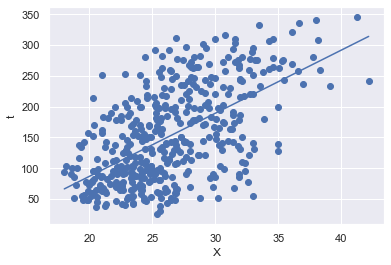

In [11]:
MyLinearRegressor1 = MyLinearRegressor()
MyLinearRegressor1.fit(X=X, y=t)
score1 = MyLinearRegressor1.score(X=X, y_true=t)

print('Score 1: ', score1)

X1 = np.reshape(X[:,ind_max_correl],(X[:,ind_max_correl].shape[0],1))
MyLinearRegressor2 = MyLinearRegressor()
MyLinearRegressor2.fit(X=X1, y=t)
score2 = MyLinearRegressor2.score(X=X1, y_true=t)

print('Score 1: ', score2)

plt.scatter(X1,t)
x = [min(X1), max(X1)]
plt.plot(x,MyLinearRegressor2.predict(x))
plt.xlabel('X')
plt.ylabel('t')
plt.show()